             precision    recall  f1-score   support

          0       0.99      0.99      0.99       123
          1       0.99      0.99      0.99       145

avg / total       0.99      0.99      0.99       268

Confusion matrix, without normalization
[[122   1]
 [  1 144]]


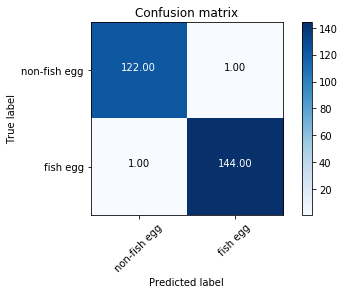

In [5]:
import pandas as pd
from tools.dataset import SPCDataset
from sklearn.metrics import confusion_matrix, classification_report
from tools.utils import plot_confusion_matrix
import cv2
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

csv_filename = '/data6/lekevin/cayman/records/model_d3/version_1/val_predictions.csv'
df = pd.read_csv(csv_filename)
print(classification_report(df.gtruth, df.predictions))
cm = confusion_matrix(df.gtruth, df.predictions)
# with open ('/data6/lekevin/cayman/data/1/labels.txt') as f:
#     labels = {int (k): v for line in f for (k, v) in (line.strip ().split (None, 1),)}
labels = ['non-fish egg', 'fish egg']
plot_confusion_matrix(cm, classes=labels, normalize=False)

Get fish egg class

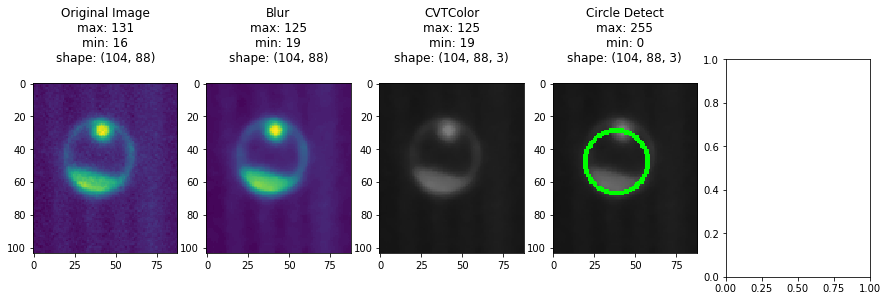

In [7]:
def debug_img(axarr, index, img, title):
    try:
        axarr[index].imshow(img)
    except:
        print(img)
    finally:
        axarr[index].set_title('{}\nmax: {}\nmin: {}\nshape: {}\n'.format(title,img.max(), img.min(), img.shape))
        
fish_egg = df.groupby(df['gtruth']).get_group(1)
img_list = fish_egg['image'].tolist()
#img_name = np.random.choice(img_list)
img_name = '/data6/lekevin/cayman/rawdata/EC1_SPC_Images_3-COLOR/SPC-BIG-1487119189-019712-008-1456-628-88-104.tif'
fig, axarr = plt.subplots(1,5, figsize=(15,4))
img = cv2.imread(img_name, 0)
debug_img(axarr, 0, img, title='Original Image')

img = cv2.medianBlur(img, 5)
debug_img(axarr, 1, img, title='Blur')

cimg = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
debug_img(axarr, 2, cimg, title='CVTColor')

circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT,1,20,param1=50,param2=30,minRadius=0,maxRadius=0)
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    cv2.circle(cimg, (i[0],i[1]),i[2],(0,255,0),2)
debug_img(axarr, 3, cimg, title='Circle Detect')

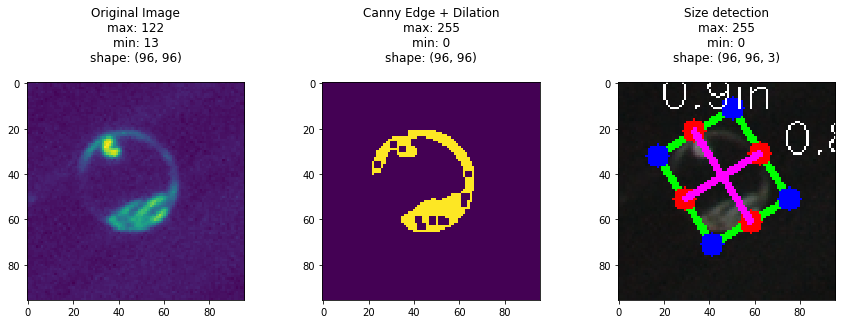

In [74]:
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2

img_name = np.random.choice(img_list)
#img_name = '/data6/lekevin/cayman/rawdata/EC1_SPC_Images_3-COLOR/SPC-BIG-1487119189-019712-008-1456-628-88-104.tif'
image1 = cv2.imread(img_name)
image = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
image = cv2.GaussianBlur(image, (1, 1), 0 ,0)
fig, axarr = plt.subplots(1,3, figsize=(15,4))
debug_img(axarr, 0, image, title='Original Image')

image = cv2.Canny(image, threshold1=10, threshold2=100)
image = cv2.dilate(image, None, iterations=1)
image = cv2.erode(image, None, iterations=1)
debug_img(axarr, 1, image, title='Canny Edge + Dilation')

cnts = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]
(cnts, _) = contours.sort_contours(cnts)
#debug_img(axarr, 2, cnts, title='Contour')

def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

pixelsPerMetric = None
for c in cnts:
    if cv2.contourArea(c) < 100:
        continue
        
    orig = image1.copy()
    box = cv2.minAreaRect(c)
    box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
    box = np.array(box, dtype='int')
    
    box = perspective.order_points(box)
    cv2.drawContours(orig, [box.astype("int")], -1, (0,255, 0), 2)
    
    for (x,y) in box:
        cv2.circle(orig, (int(x), int(y)), 5, (0,0,255), -1)
        
    (tl, tr, br, bl) = box
    (tltrX, tltrY) = midpoint(tl, tr)
    (blbrX, blbrY) = midpoint(bl, br)
    
    (tlblX, tlblY) = midpoint(tl, bl)
    (trbrX, trbrY) = midpoint(tr, br)
    
    cv2.circle(orig, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
    cv2.circle(orig, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
    cv2.circle(orig, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
    cv2.circle(orig, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)
    
    cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)), (255,0,255), 2)
    cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)), (255,0,255), 2)

    dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
    dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
    
    if pixelsPerMetric is None:
        pixelsPerMetric = dB / 0.8
        
    dimA = dA / pixelsPerMetric
    dimB = dB / pixelsPerMetric
    
    cv2.putText(orig, "{:.1f}in".format(dimA), (int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 255), 1)
    cv2.putText(orig, "{:.1f}in".format(dimB), (int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 255), 1)
    
#     plt.imshow(orig)
    debug_img(axarr, 2, orig, title='Size detection')

TypeError: debug_img() takes exactly 4 arguments (3 given)

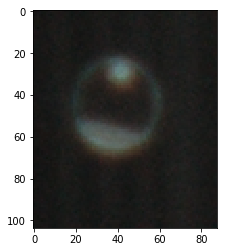